### [MTA_Subway_Trains_Delayed__Beginning_2020_20241117.csv](https://data.ny.gov/Transportation/MTA-Subway-Trains-Delayed-Beginning-2020/wx2t-qtaz/about_data)
Columns: 
- __month__: The month in which subway trains delayed is being calculated (yyyy-mm-dd).
- __division__: The A Division (numbered subway lines), B Division (lettered subway lines) and systemwide.
- __line__: Each subway line (1, 2, 3, 4, 5, 6, 7, A, C, E, B, D, F, M, G, J, Z, L, N, Q, R, W, S 42nd, S Rock, S Fkln).
- __day_type__: Represents weekday as 1 and weekend as 2.
- __reporting_category__: The six categories that delays are reported under: Infrastructure & equipment, Crew availability, Police & medical, External Factors, Operating conditions, Planned ROW work. 
- __subcategory__: The sub-categories that fall under the definition of Delays: Braking; Door-Related; Fire, Smoke, Debris; Inclement Weather; Crew Availability; Insufficient Supplement Schedule; Propulsion; Public Conduct, Crime, Police Response; Rail and Roadbed; Persons on Roadbed; Service Delivery; Sick/Injured Customer; Train Brake Activation - Cause Unknown; Subways Maintenance; Work Equipment; Capital Work - Other Planned ROW; External Debris on Roadbed; External Agency or Utility; Capital Work - Other Planned ROW; Other – CE; Other – Sig; Other Infrastructure; Other Internal Disruptions.
- __delays__: The number of train delays per category and time period.

# Data Preprocessing

In [49]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Load the dataset from the CSV file
file = 'MTA_Subway_Trains_Delayed__Beginning_2020_20241117.csv'
df = pd.read_csv(file)

# replace missing subcategories with reporting_category
df['subcategory'] = df['subcategory'].fillna(df['reporting_category'])

df

,month,division,line,day_type,reporting_category,subcategory,delays
0,2024-10-01,A DIVISION,1,1,Crew Availability,Crew Availability,60
1,2024-10-01,A DIVISION,1,1,External Factors,External Debris on Roadbed,17
2,2024-10-01,A DIVISION,1,1,Infrastructure & Equipment,Braking,20
3,2024-10-01,A DIVISION,1,1,Infrastructure & Equipment,Door-Related,43
4,2024-10-01,A DIVISION,1,1,Infrastructure & Equipment,"Fire, Smoke, Debris",30
...,...,...,...,...,...,...,...
39046,2020-01-01,B DIVISION,S Rock,2,Infrastructure & Equipment,Service Delivery,3
39047,2020-01-01,B DIVISION,S Rock,2,Operating Conditions,Operating Conditions,1
39048,2020-01-01,B DIVISION,S Rock,2,Planned ROW Work,Subways Maintenance,2
39049,2020-01-01,B DIVISION,S Rock,2,Police & Medical,"Public Conduct, Crime, Police Response",15


In [50]:
# Filter the data for the selected line
line = "N"
df = df[df['line'] == line]

# drop these variables since it's double counted information
# also drop line since we're only looking at one line
df = df.drop(columns=['division', 'reporting_category', 'line'])

# pivot the delay subcategory rows into columns
df = df.pivot(index=['month', 'day_type'], columns='subcategory', values='delays').fillna(0)

# add 2 rows with the same month but different day type, keep the month column
df = df.groupby('month').sum()


# sum the delays for each month
df['total_delays'] = df.sum(axis=1)

In [51]:
features = df.drop(columns=['total_delays'])
target = df['total_delays']

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = np.array(target).reshape(-1, 1)
scaled_target = scaler.fit_transform(scaled_target)

# Create sequences for LSTM input
def create_sequences(data, target, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return np.array(X), np.array(y)

# Use the last 6 time steps to predict the next
sequence_length = 6  
X, y = create_sequences(scaled_features, scaled_target, sequence_length)

# Reshape X to be 3D: [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)


In [52]:
print(X_train.shape[1], X_train.shape[2])
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
train_loss = model.evaluate(X_train, y_train)
test_loss = model.evaluate(X_test, y_test)
print(f'Training Loss: {train_loss}')
print(f'Test Loss: {test_loss}')


6 26
Epoch 1/100


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - loss: 0.3207 - val_loss: 0.1675
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1200 - val_loss: 0.0287
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0258 - val_loss: 0.0587
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0295 - val_loss: 0.1308
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0632 - val_loss: 0.1189
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0580 - val_loss: 0.0764
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0384 - val_loss: 0.0410
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0212 - val_loss: 0.0243
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0160 - val_loss: 0.0222
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0159 - val_loss: 0.0257
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0191 - val_loss: 0.0279
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0206 - val_loss: 0.0271


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
[[0.66041446]
 [0.70549005]
 [0.6603712 ]
 [0.5446702 ]
 [0.5916467 ]
 [0.63185656]
 [0.6043453 ]
 [0.6068511 ]
 [0.6298969 ]
 [0.680459  ]
 [0.683494  ]
 [0.6205473 ]
 [0.62636095]
 [0.6185973 ]
 [0.6135688 ]
 [0.6777997 ]]


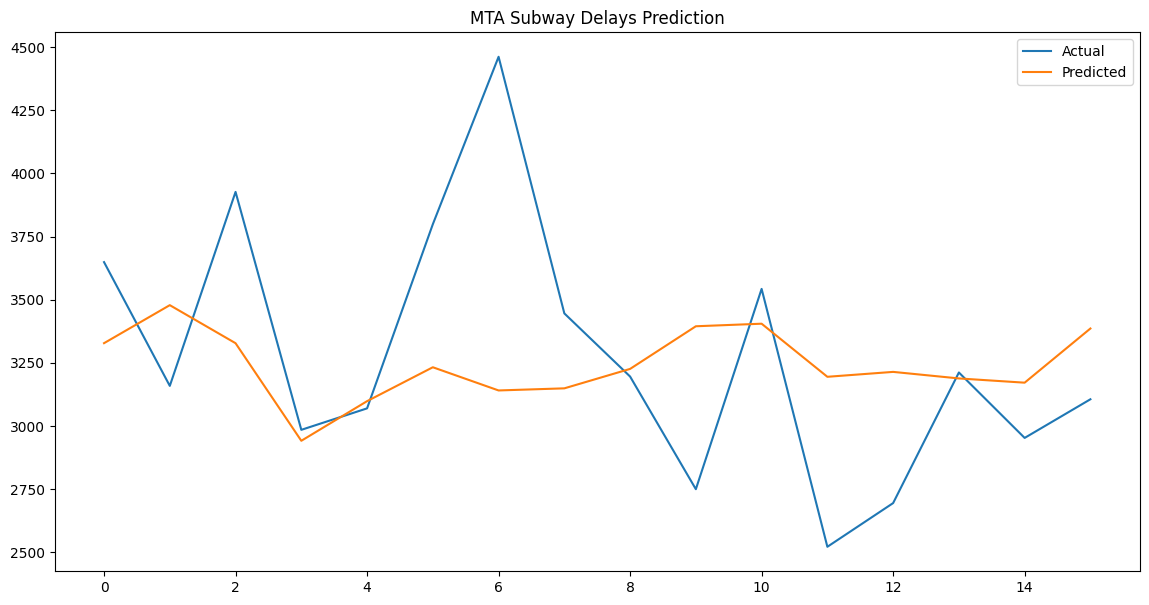

In [53]:
y_pred = model.predict(X_test)
print(y_pred)
# Invert scaling to get the actual values
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('MTA Subway Delays Prediction')
plt.legend()
plt.show()